In [1]:
import copy
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import toyplot.png
import toytree
import tqdm
from ete3 import PhyloTree, NCBITaxa
from matplotlib.lines import Line2D
from scipy.stats import describe

import AFDB_tools
import src.colorscheme as COLOR
import treescore

## Subtree (Each Protein Family)

In [2]:
def subtree_by_class(tree_in: str, cls: str, tree_out: str):
    tree = toytree.tree(tree_in)

    bar_info = {"removed": 0}
    for node in (bar := tqdm.tqdm(tree.treenode.traverse())):
        if not node.is_leaf():
            continue

        name = node.name
        bar.set_description(f"{name}")

        _cls, pdb, chain = name.split("_")
        if cls == _cls and pdb != "FM" and pdb != "SM":
            continue
        node.delete()
        bar_info["removed"] += 1
        bar.set_postfix(bar_info)

    tree.write(tree_out)

In [3]:
subtree_by_class("./wd/sum.norm.newick", "BLDB", "./wd/sum.norm.bldb.exp.newick")
subtree_by_class("./wd/sum.norm.newick", "CYTC", "./wd/sum.norm.cytc.exp.newick")
subtree_by_class("./wd/sum.norm.newick", "GFP", "./wd/sum.norm.gfp.exp.newick")
subtree_by_class("./wd/sum.norm.newick", "RAS", "./wd/sum.norm.ras.exp.newick")

subtree_by_class("./wd/fasttree.all.newick", "BLDB", "./wd/fasttree.bldb.exp.newick")
subtree_by_class("./wd/fasttree.all.newick", "CYTC", "./wd/fasttree.cytc.exp.newick")
subtree_by_class("./wd/fasttree.all.newick", "GFP", "./wd/fasttree.gfp.exp.newick")
subtree_by_class("./wd/fasttree.all.newick", "RAS", "./wd/fasttree.ras.exp.newick")

GFP_2Y0G_A: : 1517it [00:00, 2113.45it/s, removed=669] 
GFP_2Y0G_A: : 1517it [00:00, 1905.30it/s, removed=682] 
GFP_2Y0G_A: : 1517it [00:00, 2026.84it/s, removed=676] 
GFP_2Y0G_A: : 1517it [00:00, 1916.11it/s, removed=674] 
BLDB_6OOH_A: : 1517it [00:00, 2147.20it/s, removed=669]
BLDB_6OOH_A: : 1517it [00:00, 2170.27it/s, removed=682]
BLDB_6OOH_A: : 1517it [00:00, 2070.46it/s, removed=676]
BLDB_6OOH_A: : 1517it [00:00, 2105.77it/s, removed=674]


In [4]:
def plot_tree(tree_in: str, out: str, color: str):
    tree = toytree.tree(tree_in)
    tree.ladderize()
    canvas, axes, mark = tree.draw(
        ts="c",
        edge_type="p",
        height=220,
        width=300,
        tip_labels=False,
        node_sizes=[6 if n.is_leaf() else 0 for n in tree.treenode.traverse()],
        node_style={"fill": color}
    )
    toyplot.png.render(canvas, out)
    return canvas

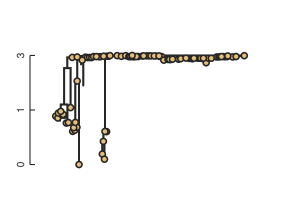

In [5]:
plot_tree("./wd/sum.norm.bldb.exp.newick", "./wd/sum.norm.bldb.exp.png", '#2A4458')
plot_tree("./wd/fasttree.bldb.exp.newick", "./wd/fasttree.bldb.exp.png", '#2A4458')

plot_tree("./wd/sum.norm.cytc.exp.newick", "./wd/sum.norm.cytc.exp.png", '#9872CA')
plot_tree("./wd/fasttree.cytc.exp.newick", "./wd/fasttree.cytc.exp.png", '#9872CA')

plot_tree("./wd/sum.norm.ras.exp.newick", "./wd/sum.norm.ras.exp.png", '#95A77E')
plot_tree("./wd/fasttree.ras.exp.newick", "./wd/fasttree.ras.exp.png", '#95A77E')

plot_tree("./wd/sum.norm.gfp.exp.newick", "./wd/sum.norm.gfp.exp.png", '#E5BE79')
plot_tree("./wd/fasttree.gfp.exp.newick", "./wd/fasttree.gfp.exp.png", '#E5BE79')

## TCS

In [2]:
SIFTS = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot"


def build_exp_trees(tree_in: str, tree_uniprot_out: str, tree_pdb_out: str):
    bar_info = {"skipped": 0, "removed": 0}
    tree_uniport = toytree.tree(tree_in)
    tree_pdb = toytree.tree(tree_in)

    # TOYTREE ver. 3.x
    # for node_uniport in (bar := tqdm.tqdm(tree_uniport[:tree_uniport.ntips])):
    # TOYTREE ver. 2.1
    for node_uniport in (bar := tqdm.tqdm(tree_uniport.treenode.traverse())):
        if not node_uniport.is_leaf():
            continue

        name = node_uniport.name
        node_pdb = tree_pdb.treenode.search_nodes(name=name)
        assert len(node_pdb) == 1
        node_pdb = node_pdb[0]

        cls, pdb, chain = name.split("_")
        if pdb == "FM" or pdb == "SM":
            node_uniport.delete()
            node_pdb.delete()
            bar_info["removed"] += 1
            continue

        respond = requests.get(f"{SIFTS}/{pdb}")
        if respond.status_code == 200:
            data = respond.json()
            uniprot_id = next(iter(data[pdb.lower()]["UniProt"].keys()))
            node_uniport.name = uniprot_id
            bar.set_description(f"{name} -> {uniprot_id}")
        else:
            bar.set_description(f"{name} -x [{respond.status_code}]")
            node_uniport.delete()
            node_pdb.delete()
            bar_info["skipped"] += 1

        bar.set_postfix(bar_info)

    tree_uniport.write(tree_uniprot_out)
    tree_pdb.write(tree_pdb_out)

In [4]:
build_exp_trees(
    tree_in="./wd/fasttree.all.newick",
    tree_pdb_out="./wd/fasttree.all.pdb.newick",
    tree_uniprot_out="./wd/fasttree.all.uniprot.newick"
)
build_exp_trees(
    tree_in="./wd/sum.norm.newick",
    tree_pdb_out="./wd/sum.norm.pdb.newick",
    tree_uniprot_out="./wd/sum.norm.uniprot.newick"
)

# build_exp_trees(
#     tree_in="./wd/sum.norm.bldb.exp.newick",
#     tree_pdb_out="./wd/sum.norm.bldb.exp.pdb.newick",
#     tree_uniprot_out="./wd/sum.norm.bldb.exp.uniprot.newick"
# )
# build_exp_trees(
#     tree_in="./wd/fasttree.bldb.exp.newick",
#     tree_pdb_out="./wd/fasttree.bldb.exp.pdb.newick",
#     tree_uniprot_out="./wd/fasttree.bldb.exp.uniprot.newick"
# )

# build_exp_trees(
#     tree_in="./wd/sum.norm.cytc.exp.newick",
#     tree_pdb_out="./wd/sum.norm.cytc.exp.pdb.newick",
#     tree_uniprot_out="./wd/sum.norm.cytc.exp.uniprot.newick"
# )
# build_exp_trees(
#     tree_in="./wd/fasttree.cytc.exp.newick",
#     tree_pdb_out="./wd/fasttree.cytc.exp.pdb.newick",
#     tree_uniprot_out="./wd/fasttree.cytc.exp.uniprot.newick"
# )
# 
# build_exp_trees(
#     tree_in="./wd/sum.norm.gfp.exp.newick",
#     tree_pdb_out="./wd/sum.norm.gfp.exp.pdb.newick",
#     tree_uniprot_out="./wd/sum.norm.gfp.exp.uniprot.newick"
# )
# build_exp_trees(
#     tree_in="./wd/fasttree.gfp.exp.newick",
#     tree_pdb_out="./wd/fasttree.gfp.exp.pdb.newick",
#     tree_uniprot_out="./wd/fasttree.gfp.exp.uniprot.newick"
# )

# build_exp_trees(
#     tree_in="./wd/sum.norm.ras.exp.newick",
#     tree_pdb_out="./wd/sum.norm.ras.exp.pdb.newick",
#     tree_uniprot_out="./wd/sum.norm.ras.exp.uniprot.newick"
# )
# build_exp_trees(
#     tree_in="./wd/fasttree.ras.exp.newick",
#     tree_pdb_out="./wd/fasttree.ras.exp.pdb.newick",
#     tree_uniprot_out="./wd/fasttree.ras.exp.uniprot.newick"
# )

BLDB_6OOH_A -> I7AP60: : 1517it [09:04,  2.78it/s, skipped=5, removed=400]    
GFP_2Y0G_A -> P42212: : 1517it [08:25,  3.00it/s, skipped=5, removed=400]    


In [27]:
# Derived from https://github.com/DessimozLab/fold_tree/
ncbi = NCBITaxa()


def retspecies_tree(species_set):
    #get ncbi tree of species set
    species_set = list(species_set)
    species_set = [int(s) for s in species_set]
    species_set = ncbi.get_topology(species_set, intermediate_nodes=True)
    return species_set


def tcs(tree_uniprot_in: str) -> (List, dict):
    tree = toytree.tree(tree_uniprot_in)
    leaves = tree.get_tip_labels()
    leaves = [x for x in leaves if x != '']
    uniprot_df = AFDB_tools.grab_entries(leaves, verbose=False)

    lineages = treescore.make_lineages(uniprot_df)
    species = treescore.get_species(uniprot_df)
    tree = treescore.label_leaves(tree, lineages, species)
    # tree = treescore.labelwRED(tree.treenode)
    overlap = treescore.getTaxOverlap(tree.treenode)
    taxscore = tree.treenode.score

    # calc descriptive stats on normalized branch lens to see if trees are balanced  
    lengths = np.array([node.dist for node in tree.treenode.traverse()])
    lengths /= np.sum(lengths)
    # calc the root first taxscore

    tree4 = copy.deepcopy(tree)
    treescore.getTaxOverlap_root(tree4.treenode)
    root_score, root_score_nr = treescore.sum_rootscore(tree4.treenode)

    species_set = set()
    # label the leaves with species and number
    for l in tree.treenode.get_leaves():
        if l.sp_num:
            l.name = l.sp_num
            species_set.add(l.sp_num.split('_')[0])

    species_tree = retspecies_tree(species_set)

    # change to phylo tree
    ncbitree = PhyloTree(species_tree.write(), sp_naming_function=None)

    # ncbitree.write(outfile="./wd/sum.norm.uniprot.ncbi.newick", format=1)
    etetree = PhyloTree(tree.write(), sp_naming_function=None)

    for l in etetree.get_leaves():
        l.species = l.name.split('_')[0]

    # ALGO 1
    # etetree.resolve_polytomy(recursive=True)
    # recon_tree, events = etetree.reconcile(ncbitree)
    # recon_dups = recon_tree.search_nodes(evoltype="D")
    # recon_losses = recon_tree.search_nodes(evoltype="L")
    # recon_speciations = recon_tree.search_nodes(evoltype="S")
    # print('algo 1')
    # print('dups:', len(recon_dups))
    # print('losses:', len(recon_losses))
    # print('speciations:', len(recon_speciations))

    # ALGO 2
    # etetree.resolve_polytomy(recursive=True)
    # print('algo 2')
    # events = etetree.get_descendant_evol_events()
    # dups = etetree.search_nodes(evoltype="D")
    # losses = etetree.search_nodes(evoltype="L")
    # speciations = etetree.search_nodes(evoltype="S")
    # print('dups:', len(dups))
    # print('losses:', len(losses))
    # print('speciations:', len(speciations))

    #measure the distances of leaves to root
    distances = np.array([node.get_distance(tree.treenode) for node in tree.treenode.get_leaves()])
    distances_norm = distances / np.mean(distances)
    summary = {
        'score': taxscore, 'stats': describe(lengths), 'ultrametricity': describe(distances),
        'ultrametricity_norm': describe(distances_norm), 'root_score': root_score, 'root_score_nr': root_score_nr,
        # 'SO_speciations': len(recon_speciations), 'SO_dups': len(recon_dups), 'SO_losses': len(recon_losses),
        # 'RECON_speciations': len(speciations), 'RECON_dups': len(dups), 'RECON_losses': len(losses)
    }

    return {n.name: n.root_score_nr for n in tree4.treenode.get_leaves()}, summary


def tcs_plot(tree_a: str, tree_b: str,
             a_label: str = 'a', b_label: str = 'b',
             a_color: str = COLOR.CS_BG, b_color: str = COLOR.CS_FG_C,
             xlim=(0, 350), ylim=(0, 350),
             ticks=[0, 50, 100, 150, 200, 250, 300, 350]
             ):
    a_tcs, a_summary = tcs(tree_a)
    b_tcs, b_summary = tcs(tree_b)

    xlabel = f'taxonomic congruence of\n{a_label} tree'
    ylabel = f'taxonomic congruence of\n{b_label} tree'

    keys = sorted(a_tcs.keys())
    df = pd.DataFrame({
        a_label: [a_tcs[k] for k in keys],
        b_label: [b_tcs[k] for k in keys]
    })
    df['color'] = np.where(df[b_label] >= df[a_label], 'b>a', 'a>b')
    color = {'b>a': b_color, 'a>b': a_color}

    print(f"sum.a={sum(df[a_label])}, sum.b={sum(df[b_label])}")
    plt.figure(figsize=(3, 3), dpi=200)
    sns.scatterplot(data=df, x=a_label, y=b_label, hue='color',
                    palette=color, s=20, alpha=0.7, linewidth=0)
    plt.plot(xlim, ylim, linestyle='dotted', color='black', linewidth=1)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.grid(False)
    for spine in plt.gca().spines.values():
        spine.set_edgecolor("k")
        spine.set_linewidth(0.5)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.gca().get_legend().remove()

    plt.legend(
        handles=[
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color['a>b'], markersize=7,
                   label=f"{a_label} better ({(df[a_label] > df[b_label]).mean() * 100:.2f}%)"),
            Line2D([0], [0], marker='o', color='w', markerfacecolor=color['b>a'], markersize=7,
                   label=f"{b_label} better ({(df[a_label] < df[b_label]).mean() * 100:.2f}%)"),
            Line2D([0], [0], linestyle='dotted', color='black',
                   label=f"identical ({(df[a_label] == df[b_label]).mean() * 100:.2f}%)", linewidth=1)
        ],
        loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=8
    )

    plt.show()

root scoring
root score 35382
root score_nr 28302
root scoring
root score 41061
root score_nr 35019
sum.a=4005, sum.b=5297


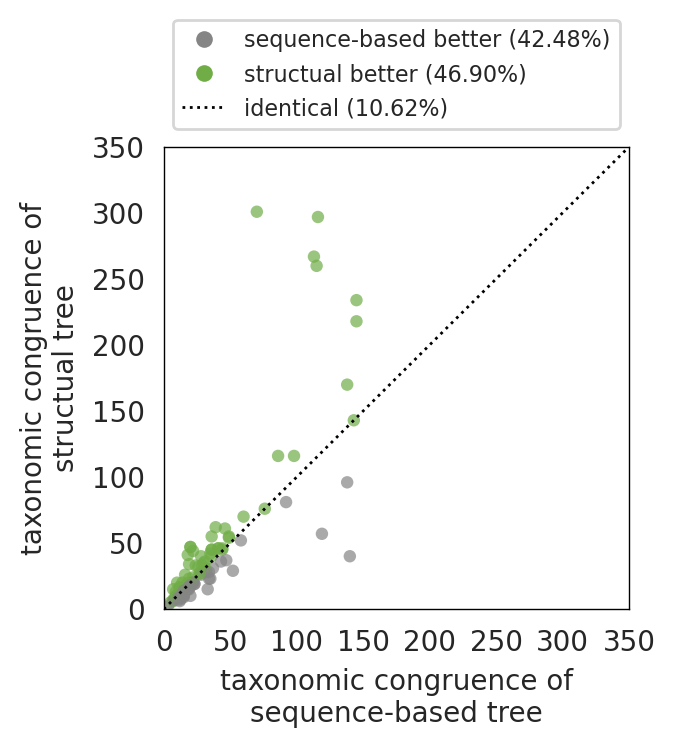

In [28]:
tcs_plot(
    tree_a="./wd/fasttree.all.uniprot.newick", a_label="sequence-based",
    tree_b="./wd/sum.norm.uniprot.newick", b_label="structual",
    xlim=(0, 350), ylim=(0, 350),
    ticks=[0, 50, 100, 150, 200, 250, 300, 350]
)